In [35]:
import pandas as pd
import numpy as np
import os
from scipy.stats import zscore

# **📂 Define Folder Containing Match CSV Files**
folder_path = '/Users/marclambertes/Python/Matches/Men/2024-2025/Premier League 2024-2025/'

# Load the team mapping file
mapping_file_path = '/Users/marclambertes/Python/Excel + CSV/opta_club_rankings_14102024.xlsx'  # Replace with your mapping file path
mapping_df = pd.read_excel(mapping_file_path)  # Assuming it has columns 'id' and 'team'

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

# **📂 Load EPV Grid**
epv = pd.read_csv("epv_grid.csv", header=None).apply(pd.to_numeric, errors='coerce').to_numpy()
epv_rows, epv_cols = epv.shape

# **🛠 Function to Load and Process a Single Match File**
def process_match(file_path):
    df = pd.read_csv(file_path)

    # Filter relevant columns
    df_filtered = df[['timeMin', 'timeSec', 'contestantId', 'typeId', 'outcome', 'x', 'y', 'playerId', 'playerName', 'keyPass']]
    df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
    df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')

    # Generate endX and endY locations
    df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
    df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))

    # Calculate pass length
    df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)

    # Compute EPV values
    df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']

    # Filter passes and shots
    passes_df = df_filtered[df_filtered['typeId'] == 1]
    shots_df = df_filtered[df_filtered['typeId'].isin([13, 14, 15, 16])]
    key_passes_df = df_filtered[df_filtered['keyPass'] == 1]

    # **Compute strategy scores per team**
    match_results = []
    for contestant in df_filtered['contestantId'].unique():
        passes_team = passes_df[passes_df['contestantId'] == contestant]
        key_passes_team = key_passes_df[key_passes_df['contestantId'] == contestant]
        shots_team = shots_df[shots_df['contestantId'] == contestant]

        team_results = {'contestantId': contestant, 'team': id_to_team.get(contestant, 'Unknown')}

        # Compute shared and unique metrics for each strategy
        for strategy, weights in strategy_weights.items():
            team_results[strategy] = calculate_strategy(passes_team, key_passes_team, shots_team, weights)

        match_results.append(team_results)

    return pd.DataFrame(match_results)

# **📂 Process All CSV Files in the Folder**
all_match_data = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        match_data = process_match(file_path)
        all_match_data.append(match_data)

# **📊 Aggregate Results: Totals & Averages**
if all_match_data:
    full_data = pd.concat(all_match_data, ignore_index=True)

    # Compute Totals
    totals = full_data.groupby(['contestantId', 'team']).sum().reset_index()

    # Compute Averages
    averages = full_data.groupby(['contestantId', 'team']).mean().reset_index()

    # Compute Z-Scores for Standardized Comparison
    standardized = averages.copy()
    standardized.iloc[:, 2:] = standardized.iloc[:, 2:].apply(zscore)

    # **📖 Save to Excel**
    with pd.ExcelWriter('strategy_metrics_overall.xlsx') as writer:
        totals.to_excel(writer, sheet_name='Total Scores', index=False)
        averages.to_excel(writer, sheet_name='Average Scores', index=False)
        standardized.to_excel(writer, sheet_name='Z-Score Standardized', index=False)

    print("✅ File saved: strategy_metrics_overall.xlsx (Totals, Averages, Z-Scores)")
else:
    print("⚠ No CSV files found in the folder!")

# **🛠 Function to Calculate Strategy Scores**
def calculate_strategy(passes, key_passes, shots, weights):
    return (
        weights['progressive'] * calculate_progressive_passes(passes) +
        weights['risk_taking'] * calculate_risk_taking_passes(passes) +
        weights['lateral_switch'] * calculate_lateral_switches(passes) +
        weights['final_third'] * calculate_final_third_passes(passes) +
        weights['under_pressure'] * calculate_under_pressure_passes(passes) +
        weights['high_value_key'] * calculate_high_value_key_passes(key_passes) +
        weights['crosses'] * calculate_crosses_into_box(passes)
    )

# **🔢 Strategy Weights for Tactical Emphasis**
strategy_weights = {
    'Caro-Kann': {'progressive': 0.2, 'risk_taking': 0.1, 'lateral_switch': 0.2, 'final_third': 0.1, 'under_pressure': 0.4, 'high_value_key': 0.1, 'crosses': 0.1},
    'Scotch Game': {'progressive': 0.4, 'risk_taking': 0.3, 'lateral_switch': 0.2, 'final_third': 0.3, 'under_pressure': 0.1, 'high_value_key': 0.2, 'crosses': 0.2},
    'Nimzo-Indian': {'progressive': 0.1, 'risk_taking': 0.1, 'lateral_switch': 0.6, 'final_third': 0.1, 'under_pressure': 0.2, 'high_value_key': 0.1, 'crosses': 0.2},
    'Sicilian Defense': {'progressive': 0.3, 'risk_taking': 0.4, 'lateral_switch': 0.1, 'final_third': 0.2, 'under_pressure': 0.1, 'high_value_key': 0.6, 'crosses': 0.3},
    'King’s Indian Defense': {'progressive': 0.3, 'risk_taking': 0.5, 'lateral_switch': 0.1, 'final_third': 0.6, 'under_pressure': 0.2, 'high_value_key': 0.2, 'crosses': 0.3},
    'Ruy-Lopez': {'progressive': 0.2, 'risk_taking': 0.1, 'lateral_switch': 0.5, 'final_third': 0.2, 'under_pressure': 0.1, 'high_value_key': 0.3, 'crosses': 0.2},
    'Queen’s Gambit': {'progressive': 0.5, 'risk_taking': 0.2, 'lateral_switch': 0.2, 'final_third': 0.3, 'under_pressure': 0.2, 'high_value_key': 0.3, 'crosses': 0.2},
    'French Defense': {'progressive': 0.1, 'risk_taking': 0.1, 'lateral_switch': 0.3, 'final_third': 0.1, 'under_pressure': 0.6, 'high_value_key': 0.1, 'crosses': 0.1},
    'Alekhine Defense': {'progressive': 0.2, 'risk_taking': 0.7, 'lateral_switch': 0.1, 'final_third': 0.3, 'under_pressure': 0.1, 'high_value_key': 0.4, 'crosses': 0.3},
    'Grünfeld Defense': {'progressive': 0.5, 'risk_taking': 0.3, 'lateral_switch': 0.1, 'final_third': 0.4, 'under_pressure': 0.1, 'high_value_key': 0.2, 'crosses': 0.2},
    'Pirc Defense': {'progressive': 0.2, 'risk_taking': 0.2, 'lateral_switch': 0.2, 'final_third': 0.3, 'under_pressure': 0.1, 'high_value_key': 0.2, 'crosses': 0.6},
}

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj44

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj44

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj44

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying 

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying 

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj44

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying 

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj44

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying 

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying 

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pass_length'] = np.sqrt((df_filtered['endX'] - df_filtered['x'])**2 + (df_filtered['endY'] - df_filtered['y'])**2)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endY'] = df_filtered['y'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:34:

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['epv'] = df_filtered['endX'] - df_filtered['x']
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying 

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['endX'] = df_filtered['x'] + np.random.uniform(-10, 10, len(df_filtered))
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_34754/2697975654.py:31: SettingWithCopyWa

✅ File saved: strategy_metrics_overall.xlsx (Totals, Averages, Z-Scores)


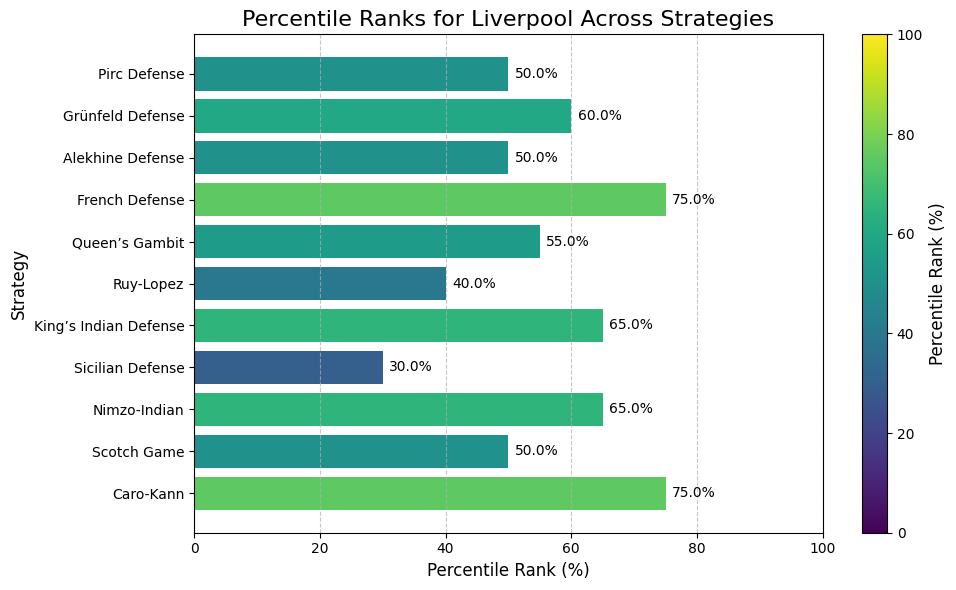

                 Strategy  Percentile Rank
0               Caro-Kann             75.0
1             Scotch Game             50.0
2            Nimzo-Indian             65.0
3        Sicilian Defense             30.0
4   King’s Indian Defense             65.0
5               Ruy-Lopez             40.0
6          Queen’s Gambit             55.0
7          French Defense             75.0
8        Alekhine Defense             50.0
9        Grünfeld Defense             60.0
10           Pirc Defense             50.0


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'strategy_metrics_overall.xlsx'
averages_df = pd.read_excel(file_path, sheet_name='Average Scores')

# Filter data for Liverpool
liverpool_data = averages_df[averages_df['team'] == 'Liverpool'].iloc[:, 2:].values.flatten()
strategies = averages_df.columns[2:]

# Calculate percentile ranks for Liverpool
percentile_ranks = []
for i, strategy in enumerate(strategies):
    # Get all team scores for the current strategy
    all_scores = averages_df[strategy]
    # Calculate percentile rank for Liverpool's score
    percentile_rank = (np.sum(all_scores < liverpool_data[i]) / len(all_scores)) * 100
    percentile_ranks.append(percentile_rank)

# Create a DataFrame for visualization
liverpool_percentiles = pd.DataFrame({
    'Strategy': strategies,
    'Percentile Rank': percentile_ranks
})

# Plot the horizontal bar graph with value-based colors
plt.figure(figsize=(10, 6))
bar_plot = plt.barh(liverpool_percentiles['Strategy'], liverpool_percentiles['Percentile Rank'], 
                    color=plt.cm.viridis(liverpool_percentiles['Percentile Rank'] / 100))  # Color based on percentile rank
plt.title('Percentile Ranks for Liverpool Across Strategies', fontsize=16)
plt.xlabel('Percentile Rank (%)', fontsize=12)
plt.ylabel('Strategy', fontsize=12)
plt.xlim(0, 100)  # Set x-axis limit to 0-100 for percentile ranks
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a color bar for reference
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Percentile Rank (%)', fontsize=12)

# Add value labels on the bars
for i, (value, strategy) in enumerate(zip(liverpool_percentiles['Percentile Rank'], liverpool_percentiles['Strategy'])):
    plt.text(value + 1, i, f'{value:.1f}%', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Print the percentile ranks
print(liverpool_percentiles)

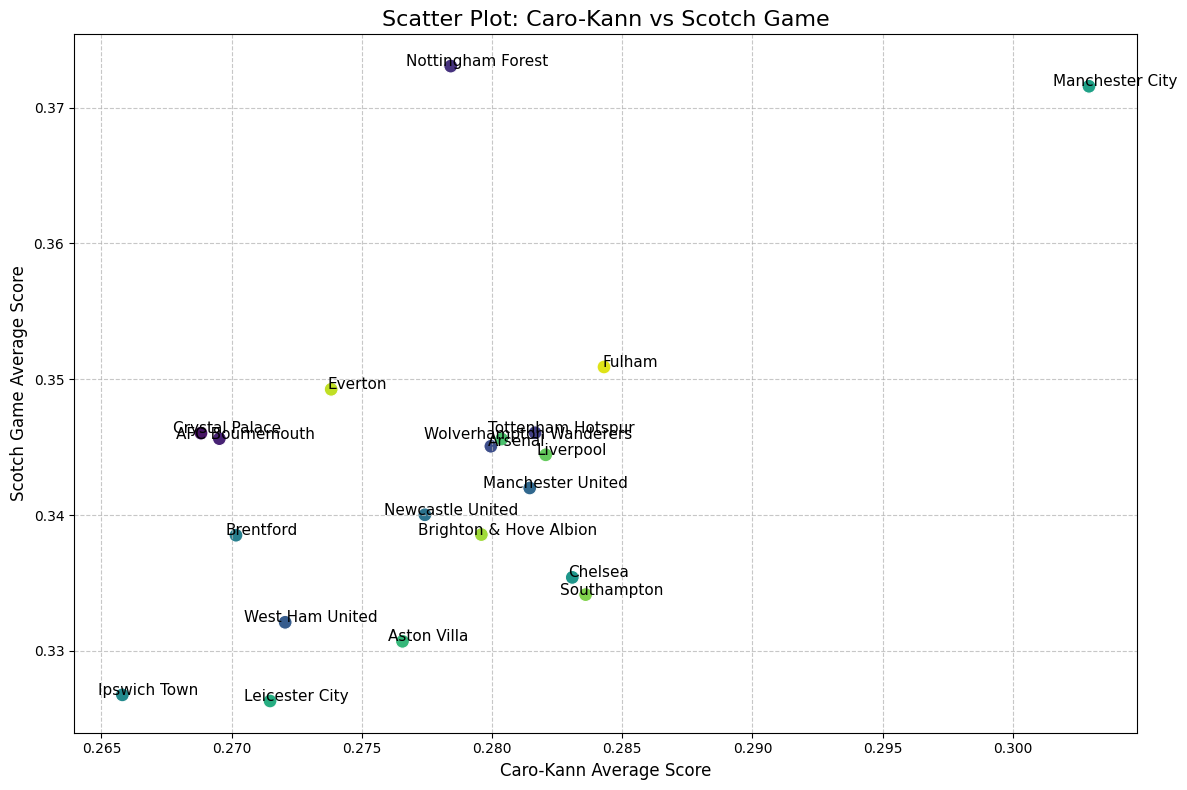

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'strategy_metrics_overall.xlsx'
averages_df = pd.read_excel(file_path, sheet_name='Average Scores')

# Define the two strategies to compare
strategy_x = 'Caro-Kann'
strategy_y = 'Scotch Game'

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=strategy_x, y=strategy_y, data=averages_df, hue='team', s=100, palette='viridis', legend=False)

# Add labels and title
plt.title(f'Scatter Plot: {strategy_x} vs {strategy_y}', fontsize=16)
plt.xlabel(f'{strategy_x} Average Score', fontsize=12)
plt.ylabel(f'{strategy_y} Average Score', fontsize=12)

# Add team names as annotations
for i, row in averages_df.iterrows():
    plt.text(row[strategy_x] + 0.001, row[strategy_y], row['team'], fontsize=11, ha='center')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

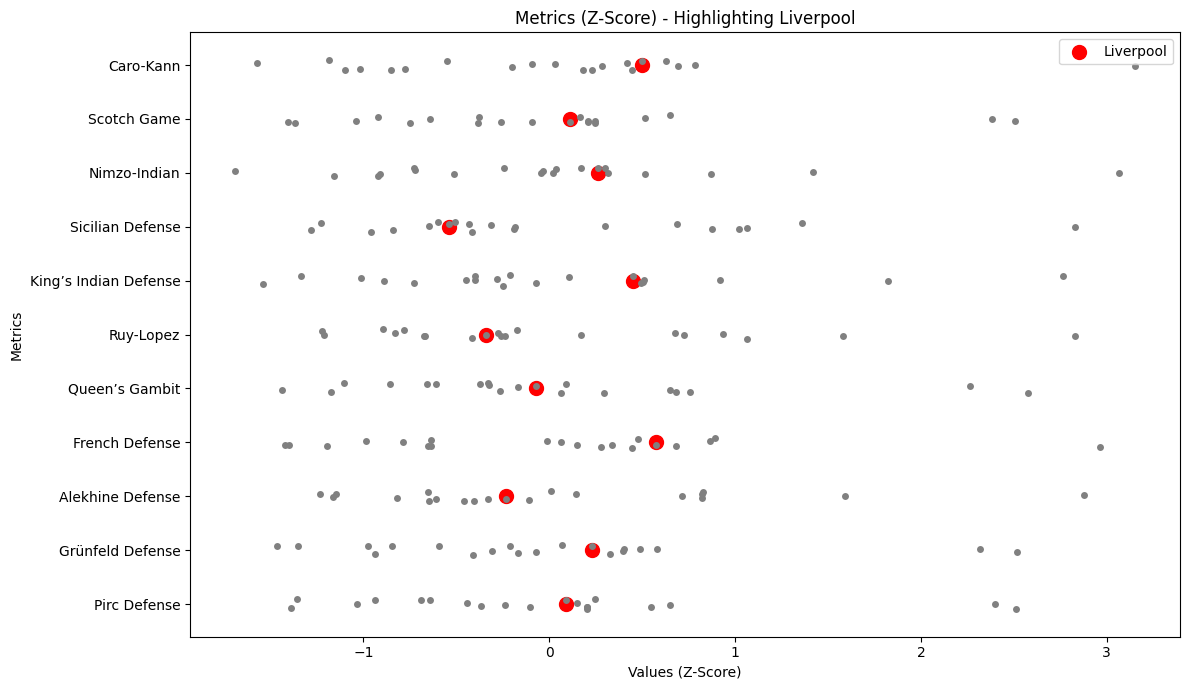

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from Excel file (ensure correct sheet name)
df = pd.read_excel('strategy_metrics_overall.xlsx', sheet_name="Z-Score Standardized")

# Ensure 'team' column exists before proceeding
if 'team' not in df.columns:
    raise ValueError("The 'team' column is missing from the dataset.")

# Exclude 'team' and 'contestantId' from metrics selection
selected_metrics = df.drop(columns=['team', 'contestantId'], errors='ignore')

# Define the team to highlight
highlight_team = 'Liverpool'

# Create a boolean column to mark Liverpool players
df['Team_Highlight'] = df['team'].eq(highlight_team)  # `.eq()` is safer

# Melt the DataFrame into long format for plotting
melted_df = df.melt(id_vars=['Team_Highlight'], value_vars=selected_metrics.columns,
                    var_name='Metric', value_name='Values')

# Plot
plt.figure(figsize=(12, 7))

# Plot all data points in grey
sns.stripplot(x='Values', y='Metric', data=melted_df, color='grey', jitter=True, size=5)

# Highlight Liverpool players in red
highlighted_players = melted_df[melted_df['Team_Highlight']]
plt.scatter(x=highlighted_players['Values'], 
            y=highlighted_players['Metric'], 
            color='red', 
            marker='o', 
            label=highlight_team, 
            s=100)

plt.xlabel('Values (Z-Score)')
plt.ylabel('Metrics')
plt.title(f'Metrics (Z-Score) - Highlighting {highlight_team}')
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
import pandas as pd
import numpy as np
import os

# **🛠 Function to Calculate Player Usage Percentage**
def calculate_player_usage(folder_path):
    player_usage = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)

            # Filter relevant columns
            df_filtered = df[['contestantId', 'playerId', 'playerName', 'typeId', 'keyPass']]

            # Calculate total team passes and actions
            team_total_passes = df_filtered[df_filtered['typeId'] == 1].groupby('contestantId').size().reset_index(name='team_total_passes')
            team_total_actions = df_filtered.groupby('contestantId').size().reset_index(name='team_total_actions')

            # Group by player and calculate total actions
            player_actions = df_filtered.groupby(['contestantId', 'playerId', 'playerName']).size().reset_index(name='total_actions')

            # Merge team totals with player actions
            player_actions = player_actions.merge(team_total_passes, on='contestantId', how='left')
            player_actions = player_actions.merge(team_total_actions, on='contestantId', how='left')

            # Calculate actions per strategy
            for strategy, weights in strategy_weights.items():
                # Filter actions based on strategy weights
                strategy_actions = df_filtered[
                    (df_filtered['typeId'] == 1) |  # Passes
                    (df_filtered['typeId'].isin([13, 14, 15, 16])) |  # Shots
                    (df_filtered['keyPass'] == 1)  # Key passes
                ]
                player_actions[strategy] = strategy_actions.groupby(['contestantId', 'playerId', 'playerName']).size().reset_index(name=strategy)[strategy]

            # Calculate usage percentage
            for strategy in strategy_weights.keys():
                # Use team_total_passes or team_total_actions as the denominator
                player_actions[f'{strategy}_usage'] = (player_actions[strategy] / player_actions['team_total_passes']) * 100

            # Append to the list
            player_usage.append(player_actions)

    # Combine all player usage data
    player_usage_df = pd.concat(player_usage, ignore_index=True)

    # Save to Excel
    player_usage_df.to_excel('player_usage_percentage.xlsx', index=False)
    print("✅ File saved: player_usage_percentage.xlsx")

# Calculate player usage percentage
calculate_player_usage(folder_path)

✅ File saved: player_usage_percentage.xlsx


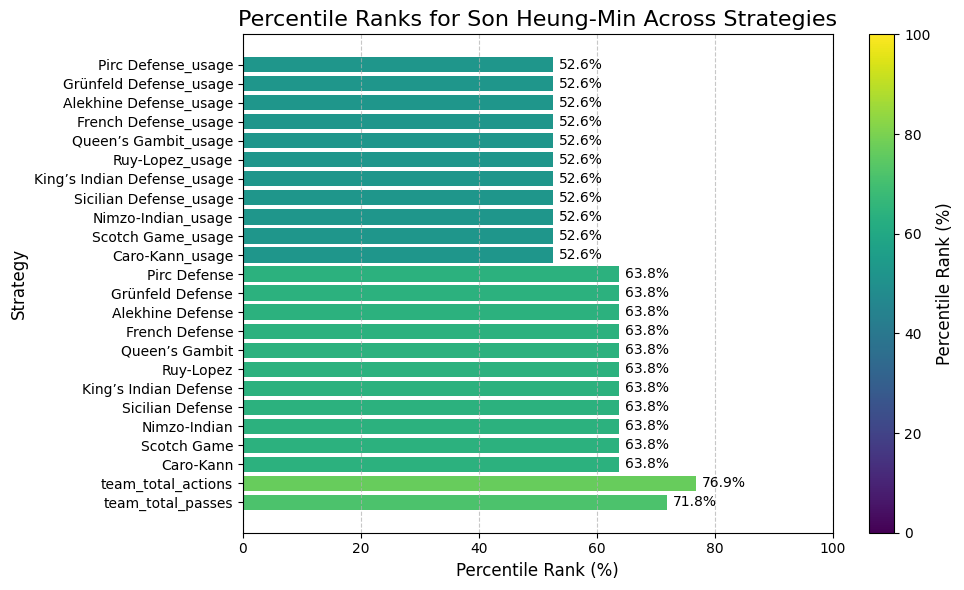

                       Strategy  Percentile Rank
0             team_total_passes        71.843834
1            team_total_actions        76.915592
2                     Caro-Kann        63.840915
3                   Scotch Game        63.840915
4                  Nimzo-Indian        63.840915
5              Sicilian Defense        63.840915
6         King’s Indian Defense        63.840915
7                     Ruy-Lopez        63.840915
8                Queen’s Gambit        63.840915
9                French Defense        63.840915
10             Alekhine Defense        63.840915
11             Grünfeld Defense        63.840915
12                 Pirc Defense        63.840915
13              Caro-Kann_usage        52.627098
14            Scotch Game_usage        52.627098
15           Nimzo-Indian_usage        52.627098
16       Sicilian Defense_usage        52.627098
17  King’s Indian Defense_usage        52.627098
18              Ruy-Lopez_usage        52.627098
19         Queen’s G

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the player usage data
player_usage_file_path = 'player_usage_percentage.xlsx'
player_usage_df = pd.read_excel(player_usage_file_path)

# Filter data for Son Heung-Min
son_data = player_usage_df[player_usage_df['playerName'] == 'Son Heung-Min'].iloc[:, 4:].values.flatten()
strategies = player_usage_df.columns[4:]  # Columns containing strategy usage percentages

# Calculate percentile ranks for Son Heung-Min
percentile_ranks = []
for i, strategy in enumerate(strategies):
    # Get all player usage percentages for the current strategy
    all_scores = player_usage_df[strategy]
    # Calculate percentile rank for Son Heung-Min's score
    percentile_rank = (np.sum(all_scores < son_data[i]) / len(all_scores)) * 100
    percentile_ranks.append(percentile_rank)

# Create a DataFrame for visualization
son_percentiles = pd.DataFrame({
    'Strategy': strategies,
    'Percentile Rank': percentile_ranks
})

# Plot the horizontal bar graph with value-based colors
plt.figure(figsize=(10, 6))
bar_plot = plt.barh(son_percentiles['Strategy'], son_percentiles['Percentile Rank'], 
                    color=plt.cm.viridis(son_percentiles['Percentile Rank'] / 100))  # Color based on percentile rank
plt.title('Percentile Ranks for Son Heung-Min Across Strategies', fontsize=16)
plt.xlabel('Percentile Rank (%)', fontsize=12)
plt.ylabel('Strategy', fontsize=12)
plt.xlim(0, 100)  # Set x-axis limit to 0-100 for percentile ranks
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a color bar for reference
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Percentile Rank (%)', fontsize=12)

# Add value labels on the bars
for i, (value, strategy) in enumerate(zip(son_percentiles['Percentile Rank'], son_percentiles['Strategy'])):
    plt.text(value + 1, i, f'{value:.1f}%', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Print the percentile ranks
print(son_percentiles)